## Семинар 2 "Распознавание рукописных цифр"

ФИО: Полыковский Даниил Александрович

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torch import Tensor
import numpy as np
import sys
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output
%matplotlib inline

In [2]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [3]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

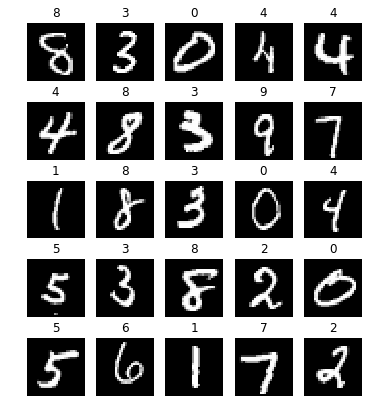

In [4]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [5]:
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None, extra_batch=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    train_loader = []
    if extra_batch:
        train_loader = DataLoader(train_dataset + batch, 
                                  batch_size=32, shuffle=True)
    else:
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [6]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 9... (Train/Test) NLL: 0.057/0.094	Accuracy: 0.985/0.972

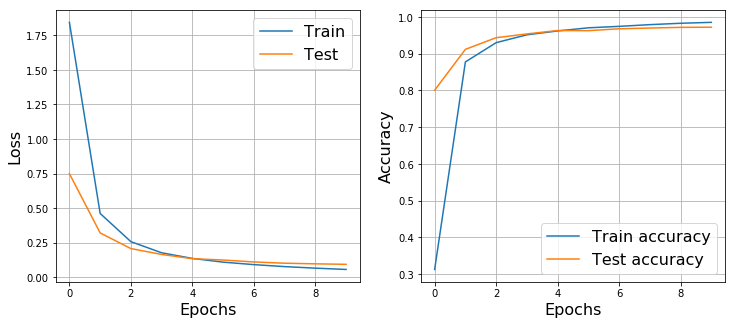

In [7]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 10, 0.1)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [8]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

In [9]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 9... (Train/Test) NLL: 0.020/0.108	Accuracy: 0.993/0.976

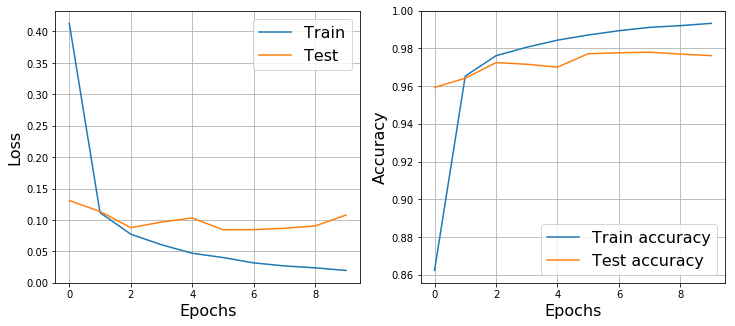

In [10]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 10, 0.1, plot=True, verbose=True)

Epoch 9... (Train/Test) NLL: 0.015/0.077	Accuracy: 0.995/0.982

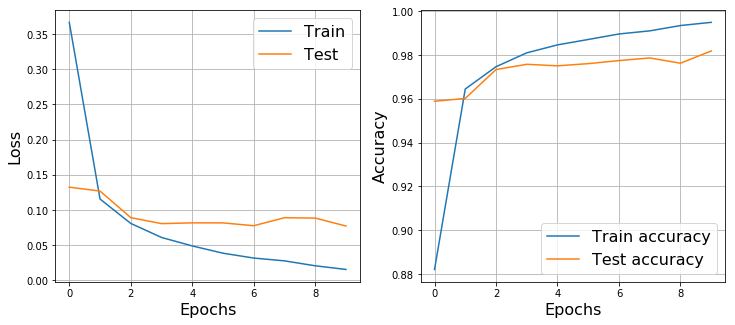

In [11]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 10, 0.1, plot=True, verbose=True)

### HW1 (1 балл): Реализовать Tanh

In [12]:
class Tanh:
    def __init__(self):
        pass
    
    def forward(self, X):
        self.X = X
        s = np.exp(2 * X)
        self.Y = (s - 1.) / (s + 1.)
        return self.Y
    
    def backward(self, dLdy):
        s = np.exp(2 * self.X)
        self.dLdx = dLdy * 4. * s / (s + 1.) ** 2
        return self.dLdx
    
    def step(self, learning_rate):
        pass

Проверим правильность реализации:

In [13]:
def check_gradient(func, X, gradient):
    eps = 10 ** (-6)
    
    f_grad = np.zeros(gradient.shape)
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X[i, j] += eps            
            f_r = func(X)
            X[i, j] -= 2*eps            
            f_l = func(X)            
            X[i, j] += eps        
            f_grad[i, j] = (f_r - f_l) / 2 / eps
            
    return np.max(np.abs(gradient - f_grad))

In [14]:
X = np.array([[0, 1], [1, 1]], dtype=np.float64)
Y = np.array([[0], [1]])

l = Linear(2, 1)

def loss1(W):
    l.W = W
    res = l.forward(X)
    return np.sum((res - Y)**2)

def loss2(X):
    res = l.forward(X)
    return np.sum((res - Y)**2)

res = l.forward(X)
dLdy = 2 * (res - Y)
l.backward(dLdy)

print("dLdw: ", check_gradient(loss1, l.W, l.dLdW))
print("dLdx: ", check_gradient(loss2, X, l.dLdx))

dLdw:  6.987499467925318e-11
dLdx:  8.449181632119718e-11


Epoch 9... (Train/Test) NLL: 0.016/0.092	Accuracy: 0.995/0.976

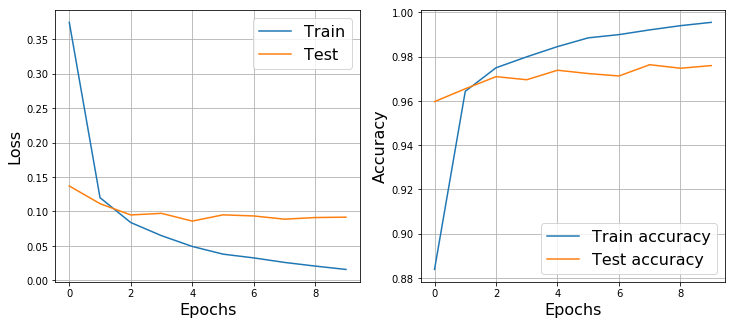

In [15]:
network = NeuralNetwork([
    Linear(784, 100), Tanh(),
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_t, ts_t, tr_ac_t, ts_ac_t = train(network, 10, 0.1, plot=True, verbose=True)

Сравним результаты обучения при выборе разных нелинейностей:

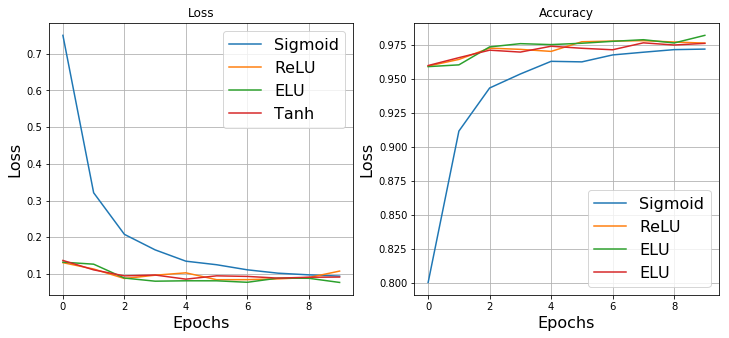

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.plot(ts_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.plot(ts_ac_t, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### Часть 3: Анализ ошибок

In [17]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

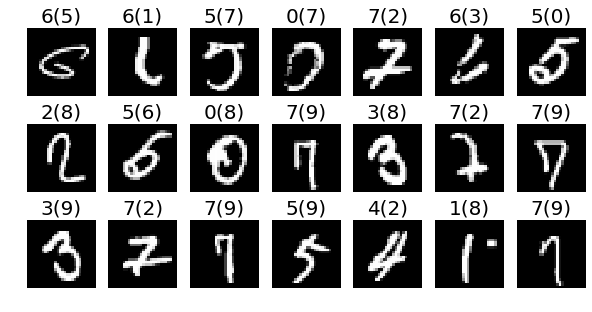

In [18]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]],
                              predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

In [19]:
Tensor(wrong_X[0].reshape(1, 28, 28)).size()

torch.Size([1, 28, 28])

In [20]:
wrong_X.shape

(241, 784)

In [21]:
train_dataset[0][0].size()

torch.Size([1, 28, 28])

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [22]:
from skimage.transform import rotate
import copy
import random
random.seed(555)

In [23]:
tmp = list(copy.deepcopy(train_dataset))

In [24]:
def imrotate(images, max_angle=15):
    batch = []
    for i in range(len(images)):
        batch.append((Tensor(rotate(images[i][0].resize(28, 28),
                                    random.randint(-max_angle, max_angle))).resize(1, 28, 28), images[i][1]))
    return batch

def imshift(_images, shift=1, sight='left'):
    images = list(copy.deepcopy(_images))
    if sight == 'left':
        for j in range(len(images)):
            for i in range(images[j][0][0].size()[1] - shift):
                images[j][0][0][:, i] = images[j][0][0][:, i + shift]
            for i in range(-2, -shift - 1, -1):
                images[j][0][0][:, i] = images[j][0][0][:, -1]

            for i in range(images[j][0][0].size()[0] - shift):
                images[j][0][0][i, :] = images[j][0][0][i + shift, :]
            for i in range(-2, -shift - 1, -1):
                images[j][0][0][i, :] = images[j][0][0][-1, :]
    elif sight == 'right':
        for j in range(len(images)):
            for i in range(1, images[j][0][0].size()[1] - shift + 1):
                images[j][0][0][:,
                                images[j][0][0].size()[1] - i] 
                = images[j][0][0][:, images[j][0][0].size()[1] - i - shift]
            for i in range(1, shift):
                images[j][0][0][:, i] = images[j][0][0][:, 0]

            for i in range(images[j][0][0].size()[0] - shift):
                images[j][0][0][i, :] = images[j][0][0][i + shift, :]
            for i in range(-2, -shift - 1, -1):
                images[j][0][0][i, :] = images[j][0][0][-1, :]
    return images

def imnoise(_images, coef=0.1):
    images = list(copy.deepcopy(_images))
    for j in range(len(images)):
        images[j][0][0] = images[j][0][0] + Tensor(np.random.randn(28, 28)) * coef
    return images

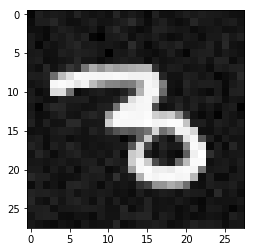

In [25]:
batch = imnoise(tmp)
plt.imshow(batch[30][0].reshape(28, 28), cmap=plt.cm.Greys_r)

Epoch 9... (Train/Test) NLL: 0.030/0.075	Accuracy: 0.994/0.978

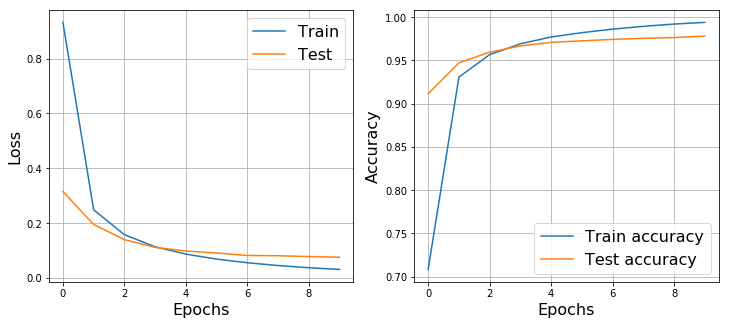

In [26]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
tr_t_n, ts_t_n, tr_ac_t_n, ts_ac_t_n = train(network, 10, 0.01, extra_batch=batch)

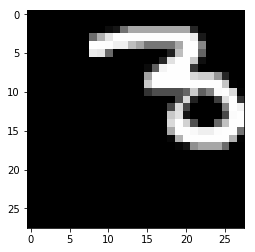

In [27]:
batch = imshift(tmp, shift=5, sight='right')
plt.imshow(batch[30][0].reshape(28, 28), cmap=plt.cm.Greys_r)

Epoch 9... (Train/Test) NLL: 0.066/0.107	Accuracy: 0.981/0.968

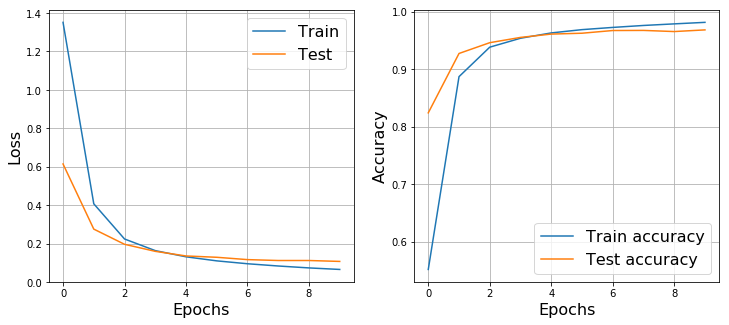

In [28]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
tr_t_s, ts_t_s, tr_ac_t_s, ts_ac_t_s = train(network, 10, 0.01, extra_batch=batch)

C:\Users\miracle\Anaconda3\lib\site-packages\torch\tensor.py:293: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


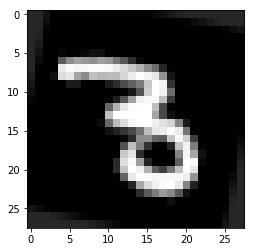

In [29]:
batch = imrotate(tmp)
plt.imshow(batch[30][0].reshape(28, 28), cmap=plt.cm.Greys_r)

Epoch 9... (Train/Test) NLL: 0.051/0.070	Accuracy: 0.986/0.979

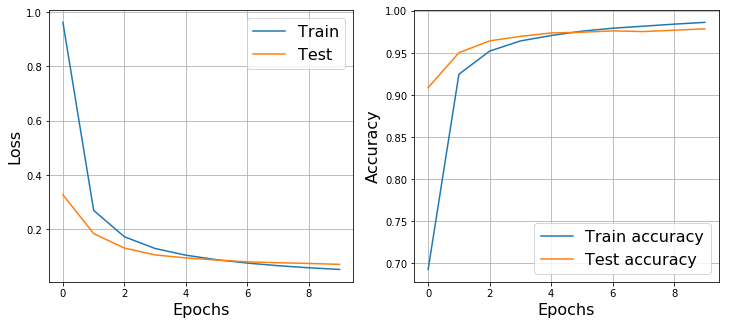

In [30]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
tr_t_r, ts_t_r, tr_ac_t_r, ts_ac_t_r = train(network, 10, 0.01, extra_batch=batch)

Аугментация каждого вида по отдельности на данных, на которых модель ошибается, весомого прироста не дала (хотя нормальный шум и поворот немного улучшили картину). Попробуем объединить все виды аугментации.

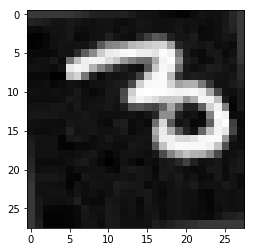

In [31]:
batch = imrotate(imshift(imnoise(tmp), 3, 'right'))
plt.imshow(batch[30][0].reshape(28, 28), cmap=plt.cm.Greys_r)

Epoch 9... (Train/Test) NLL: 0.071/0.092	Accuracy: 0.979/0.970

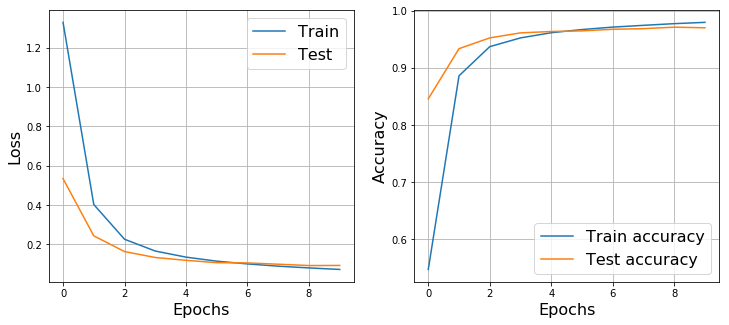

In [32]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
tr_t_a, ts_t_a, tr_ac_t_a, ts_ac_t_a = train(network, 10, 0.01, extra_batch=batch)

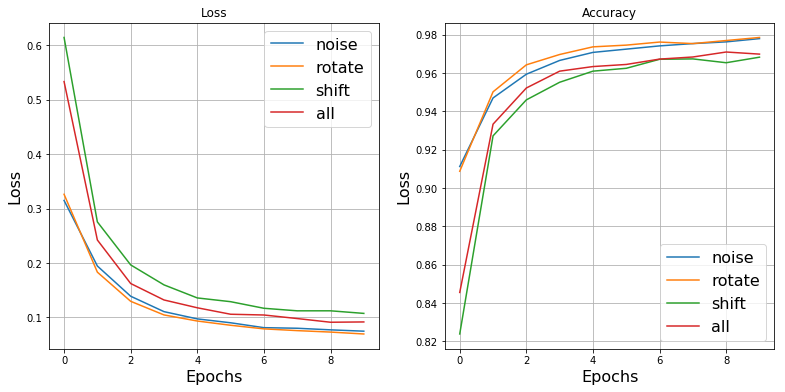

In [33]:
plt.figure(figsize=(13, 6))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_t_n, label='noise')
plt.plot(ts_t_r, label='rotate')
plt.plot(ts_t_s, label='shift')
plt.plot(ts_t_a, label='all')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_t_n, label='noise')
plt.plot(ts_ac_t_r, label='rotate')
plt.plot(ts_ac_t_s, label='shift')
plt.plot(ts_ac_t_a, label='all')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

Выбить результат лучше не удается, модель успевает только переобучиться.

В итоге лучший результат на тесте показала аугментация с нормальным шумом.

Проведем те же махинации для ELU, Sigmoid и ReLU.

Epoch 9... (Train/Test) NLL: 0.085/0.085	Accuracy: 0.974/0.973

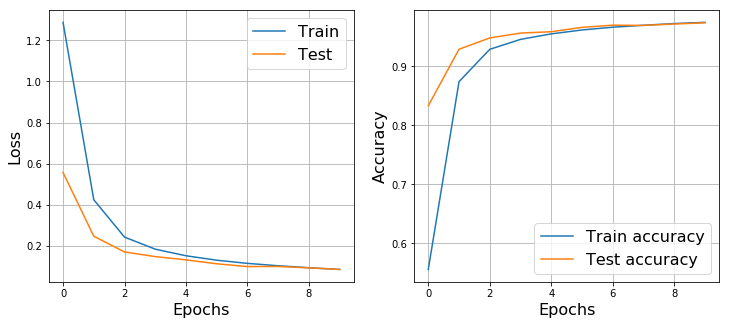

In [34]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 10, 0.01,
                                     plot=True, verbose=True,
                                     extra_batch=batch)

Epoch 9... (Train/Test) NLL: 0.065/0.107	Accuracy: 0.980/0.967

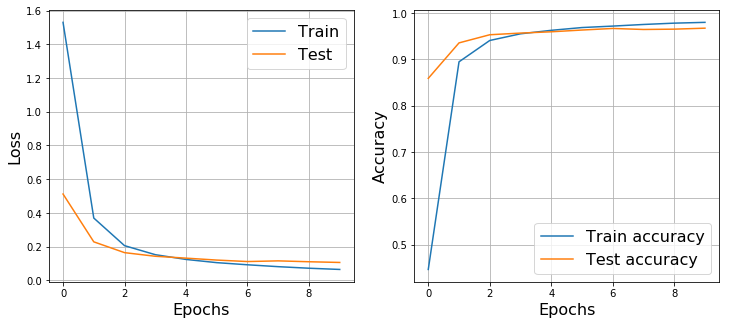

In [35]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)])
loss = NLLLoss()
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 10, 0.1,
                                     plot=True, verbose=True,
                                     extra_batch=batch)

Epoch 9... (Train/Test) NLL: 0.036/0.110	Accuracy: 0.988/0.973

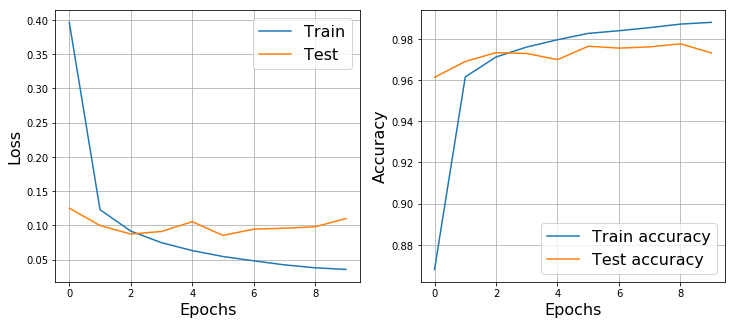

In [36]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 10, 0.1,
                                     plot=True, verbose=True,
                                     extra_batch=batch)

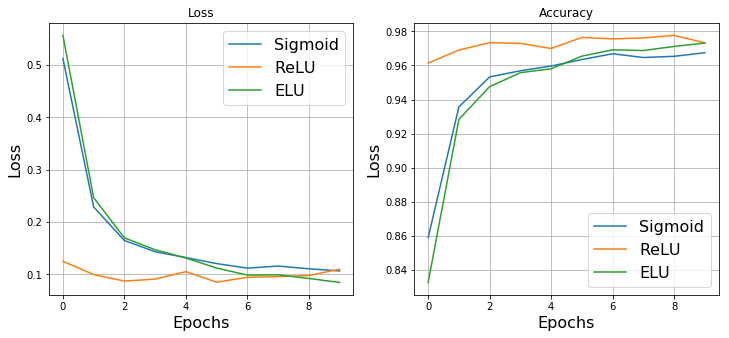

In [37]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

Сравнивая результаты обучения, можно сделать вывод, что нелинейность влияет на сходимость (лучший результат на test показал гиперболический тангенс). Использование аугментации в виде нормального шума и поворота для той же нелинейности выдало по итогу лучший результат ~0.07 на test, что не особо прибавило качества в сранении с лучшим результатом без аугментации (ELU, 0.077). Композиция аугментаций не дала прироста эффективности классификации ни для одной нелинейности. Пришлось уменьшить для большинства нелинейностей скорость сходимости в 10 раз из-за увеличения объема выборки (для изначального learning rate = 0.1 переобучение было вплоть до ошибки, равной 0.001 на train)

Итак, можно сделать вывод, что выбор нелинейности и предобработка данных существенно влияет на результаты обучения.